<a href="https://colab.research.google.com/github/beyda1221/YapayZeka/blob/main/Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Gerekli kütüphaneleri yükle
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, count, when, abs
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
from google.colab import drive

#  Spark Oturumu Başlat
spark = SparkSession.builder.appName("CaliforniaHousing").getOrCreate()

In [10]:
# Google Drive Bağlantısı Ve Veri Okuma
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/housing.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True).dropna()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Feature Selection Ve Feature Engineering
feature_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                'total_bedrooms', 'population', 'households', 'median_income']

# Feature Vector Dönüştürme
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Normalizasyon (StandardScaler)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)



In [12]:
#  Train-Test Split (80-20 ve 70-30)**
train_data_80, test_data_20 = df.randomSplit([0.8, 0.2], seed=42)
train_data_70, test_data_30 = df.randomSplit([0.7, 0.3], seed=42)


In [13]:
#  Model Tanımlamaları
models = {
    "Linear Regression": LinearRegression(featuresCol="scaledFeatures", labelCol="median_house_value"),
    "Random Forest": RandomForestRegressor(featuresCol="scaledFeatures", labelCol="median_house_value", numTrees=10),
    "GBT Regression": GBTRegressor(featuresCol="scaledFeatures", labelCol="median_house_value", maxIter=50) }

In [14]:
#  Model Eğitimi & Değerlendirme
results = {}

for name, model in models.items():
    trained_model = model.fit(train_data_80)
    predictions = trained_model.transform(test_data_20)

    # Performans Metrikleri
    rmse = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse").evaluate(predictions)
    r2 = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2").evaluate(predictions)

    results[name] = {"RMSE": rmse, "R2": r2}

    print(f"\n🔹 Model: {name}")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - R2 Score: {r2:.4f}")


🔹 Model: Linear Regression
  - RMSE: 69685.93
  - R2 Score: 0.6323

🔹 Model: Random Forest
  - RMSE: 75509.00
  - R2 Score: 0.5683

🔹 Model: GBT Regression
  - RMSE: 54162.55
  - R2 Score: 0.7779


In [15]:
# MAPE Hesaplama Fonksiyonu
def calculate_mape(df, label_col="median_house_value", pred_col="prediction"):
    df = df.withColumn("APE", abs(col(label_col) - col(pred_col)) / col(label_col))
    return df.select(mean(col("APE"))).collect()[0][0] * 100

# Tüm Modeller için MAPE Hesaplama
for name, model in models.items():
    trained_model = model.fit(train_data_80)
    predictions = trained_model.transform(test_data_20)
    mape = calculate_mape(predictions)

    results[name]["MAPE"] = mape
    print(f"📌 {name} MAPE: {mape:.2f}%")

📌 Linear Regression MAPE: 29.96%
📌 Random Forest MAPE: 34.87%
📌 GBT Regression MAPE: 21.45%


In [17]:
#  Train ve Test Loss Karşılaştırma Grafiği
train_rmse, test_rmse = {}, {}

for name, model in models.items():
    train_rmse[name] = []
    test_rmse[name] = []


    if hasattr(model, 'maxIter'):
        param_name = 'maxIter'
    else:
        param_name = 'numTrees'

    for epoch in range(1, 11):
        trained_model = model.copy({getattr(model, param_name): epoch}).fit(train_data_80)

        train_rmse[name].append(RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse").evaluate(trained_model.transform(train_data_80)))
        test_rmse[name].append(RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse").evaluate(trained_model.transform(test_data_20)))

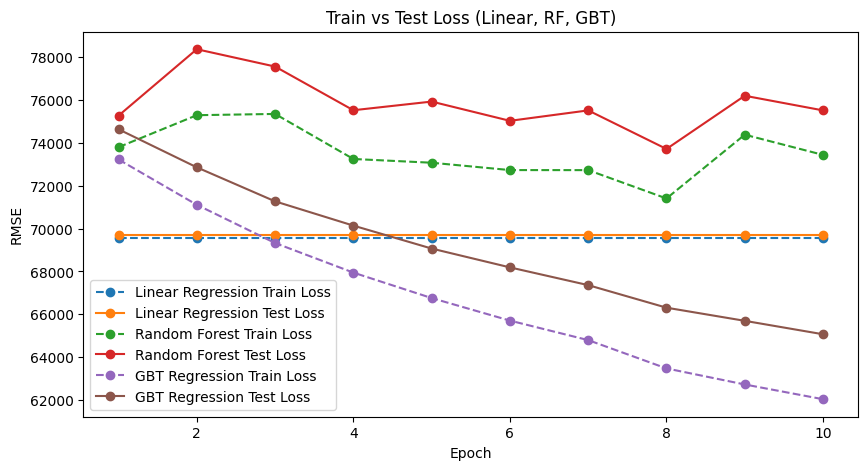

In [18]:
# Grafik Çizimi
plt.figure(figsize=(10, 5))

for name in models.keys():
    plt.plot(range(1, 11), train_rmse[name], label=f"{name} Train Loss", linestyle="--", marker="o")
    plt.plot(range(1, 11), test_rmse[name], label=f"{name} Test Loss", marker="o")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.title("Train vs Test Loss (Linear, RF, GBT)")
plt.show()
